<a href="https://colab.research.google.com/github/enVives/Caltech101/blob/main/Caltech101.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [257]:
from itertools import filterfalse
from collections import OrderedDict
import torch,torchvision
import numpy as np
import pandas as pd
import math
import cv2
import time
import os
import wandb
import pylab as pl
import scipy.io
import matplotlib.pyplot as plt


from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score
from tqdm.auto import tqdm
from torchvision import transforms,models
from torch import nn
from IPython.display import clear_output,display
from torch.utils.data import DataLoader, random_split,Subset,Dataset
from google.colab.patches import cv2_imshow
from PIL import Image
from sklearn.preprocessing import LabelEncoder
from glob import glob

ROOT = './sample_data/'
CLASS_A = 'cougar_body'
CLASS_B = 'windsor_chair'

DOWNLOAD = False
wandb.login()
#471be466c8949671a46c67e7aad0d5a0ac8c9dad
#!rm -rf /content/sample_data/*
# torch.cuda.default_stream(torch.device('cuda'))

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [258]:
def find_mean_std(dataset):
  dataloader = DataLoader(dataset,batch_size = 1,shuffle=FALSE)
  mean = torch.zeros(3)
  std = torch.zeros(3)
  samples = 0

  for image,_ in dataloader:
    mean += image.mean(dim=[0, 2, 3])  # Mean for each channel [batchsize,channels,height,width]
    std += image.std(dim=[0, 2, 3])    # Std for each channel
    samples += 1

  mean /= samples
  std /= samples

  print(mean)
  print(std)

In [259]:
from pickle import NONE
class Formes(Dataset):
    def __init__(self, paths, labels= None, transforms = None,annotations = None,transform_mask = None):
        self.images = paths
        self.labels = labels
        self.transforms = transforms
        self.annotations = annotations
        self.transforms_mask = transform_mask

    def __len__(self):
        return len(self.labels)

    def __getdist__(self):
      return pd.Series(self.labels).value_counts()

    def __showcontours__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      plt.imshow(image)

      mat_data = scipy.io.loadmat(self.annotations[index])
        #print("Keys in MAT file:", polygons_data.keys())

      polygons_data = mat_data['obj_contour']

      x_points = polygons_data[0]
      y_points = polygons_data[1]

      contour_points = np.array(list(zip(x_points,y_points)))

      plt.plot(contour_points[:, 0], contour_points[:, 1], '-r')  # Red contour line
      plt.scatter(contour_points[:, 0], contour_points[:, 1], c='blue')  # Optional: Mark contour points
      plt.show()

    def __getpureimage__(self,index):
      path = self.images[index]
      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
      return image

    def __getitem__(self, index):
      path = self.images[index]
      label = self.labels[index]

      if self.annotations != None:
        mat_data = scipy.io.loadmat(self.annotations[index])
        #print("Keys in MAT file:", polygons_data.keys())

        polygons_data = mat_data['obj_contour']
        boundingbox_data = mat_data['box_coord']

        x_points = polygons_data[0]
        y_points = polygons_data[1]

        contour_points = list(zip(x_points,y_points))
        contour = np.array(contour_points, dtype=np.int32)

        #print(contour_points)


      image = cv2.imread(path, cv2.IMREAD_COLOR)
      image = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

      if self.annotations != None:
        mask = np.zeros(image.size, dtype=np.uint8)
        cv2.fillPoly(mask, [contour], color=255)  # White filled polygon
        mask = Image.fromarray(mask)  # Convert NumPy array to PIL Image
        mask_resized = self.transforms_mask(mask)

        image = self.transforms(image)

        return image, mask_resized

      image = self.transforms(image)

      return image, label

In [260]:
def get_labels(sett):
  labels = np.array([])
  frequency = np.zeros(101)
  for _,label in sett:
    labels = np.append(labels,label)
    frequency[label] += 1
  return labels.astype(int),frequency

In [261]:
#from pickle import FALSE
from sklearn.model_selection import train_test_split

TRAINING = 0.80
VAL = 0.10
TESTING = 0.10

#[0.5459, 0.5288, 0.5022]
#[0.2424, 0.2393, 0.2409]
mean = torch.tensor([0.485,0.456,0.406])
std = torch.tensor([0.229,0.224,0.225])

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

transform_masks = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])


transform2 = transforms.Compose([
    #transforms.Lambda(lambda img: img.convert("RGB") if img.mode != "RGB" else img),  # Ensure all images are RGB
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dataset = torchvision.datasets.Caltech101(root= ROOT,download=DOWNLOAD,transform=transform)
img_class_1 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/cougar_body/*'))
img_class_2 = sorted(glob('/content/sample_data/caltech101/101_ObjectCategories/windsor_chair/*'))

img_annotations_class_1 = sorted(glob('/content/sample_data/caltech101/Annotations/cougar_body/*'))
img_annotations_class_2 = sorted(glob('/content/sample_data/caltech101/Annotations/windsor_chair/*'))


img_files = img_class_1 +  img_class_2
img_annotations = img_annotations_class_1 + img_annotations_class_2

labels = []
for img_path in img_files:
  label = img_path.split(os.path.sep)[-2]
  labels.append(label)

lb = LabelEncoder()
labels = lb.fit_transform(labels)

weights = 1.0 / pd.Series(labels).value_counts()
weights = weights / weights.sum()
weights = torch.tensor(weights,dtype=torch.float32)

X_train, X_test, y_train, y_test, annotations_train, annotations_test = train_test_split(
    img_files, labels, img_annotations, test_size=TESTING, random_state=42, stratify=labels
)

# Split the training set further into training and validation sets
X_train, X_val, y_train, y_val, annotations_train, annotations_val = train_test_split(
    X_train, y_train, annotations_train, test_size=VAL/(TRAINING+VAL), random_state=42, stratify=y_train
)

training = Formes(X_train,y_train,transform,annotations_train,transform_masks)
testing = Formes(X_test,y_test,transform,annotations_test,transform_masks)
validation = Formes(X_val,y_val,transform,annotations_val,transform_masks)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#training,validation,testing = random_split(dataset,[train_size,validation_size,len(dataset)-train_size-validation_size])

In [262]:
print(f"LONGITUD SET DE TRAINING: {training.__len__()}")
with open("training.txt", "w") as file:
    for item in training.__getdist__()/training.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE VALIDATION: {validation.__len__()}")
with open("valid.txt", "w") as file:
    for item in validation.__getdist__()/validation.__len__():
        file.write(f"{item}\n")
print(f"LONGITUD SET DE TESTING: {testing.__len__()}")

LONGITUD SET DE TRAINING: 81
LONGITUD SET DE VALIDATION: 11
LONGITUD SET DE TESTING: 11


Ara ja sabem que hem de predir si una imatge pertany a les classes 25 o 99

In [263]:
def veure_imatges(train_data,std,mean):
  for i in range(len(train_data)):
    imatge,label = train_data[i]

    print(imatge.ndimension())
    print(imatge.shape)

    imatge = imatge * (std[:, None, None]*255) + (mean[:, None, None]*255)
    # Convert the tensor back to a NumPy array
    img_numpy = imatge.permute(1, 2, 0).numpy()  # Change from (C, H, W) to (H, W, C)
    cv2_imshow(img_numpy)
    time.sleep(5)
    clear_output(wait=True)

In [264]:
class UNet(nn.Module):

    def __init__(self, in_channels=3, out_channels=1, init_features=32):
        super(UNet, self).__init__()

        features = init_features

        ## CODER
        self.encoder1 = UNet._block(in_channels, features, name="enc1")
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder2 = UNet._block(features, features * 2, name="enc2")
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder3 = UNet._block(features * 2, features * 4, name="enc3")
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.encoder4 = UNet._block(features * 4, features * 8, name="enc4")
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.bottleneck = UNet._block(features * 8, features * 16, name="bottleneck")

        ## DECODER

        self.upconv4 = nn.ConvTranspose2d(features * 16, features * 8, kernel_size=2,
                                          stride=2)  # Empra aquesta capa com exemple
        self.decoder4 = UNet._block(features * 16, features * 8, name="dec4")

        self.upconv3 = nn.ConvTranspose2d(features * 8, features * 4, kernel_size=2, stride=2)
        self.decoder3 = UNet._block(features * 8, features * 4, name="dec3")

        self.upconv2 = nn.ConvTranspose2d(features * 4, features * 2, kernel_size=2, stride=2)
        self.decoder2 = UNet._block(features * 4, features * 2, name="dec2")

        self.upconv1 = nn.ConvTranspose2d(features * 2, features, kernel_size=2, stride=2)
        self.decoder1 = UNet._block(features * 2, features, name="dec1")

        self.final = nn.Conv2d(
            in_channels=features,
            out_channels=out_channels,
            kernel_size=1,
            padding=0,
            bias=False,
        )

    def forward(self, x):
        enc1 = self.encoder1(x)
        enc2 = self.encoder2(self.pool1(enc1))
        enc3 = self.encoder3(self.pool2(enc2))
        enc4 = self.encoder4(self.pool3(enc3))

        bottleneck = self.bottleneck(self.pool4(enc4))

        dec1 = self.upconv4(bottleneck)
        dec1 = torch.cat((dec1, enc4), dim=1)
        dec2 = self.decoder4(dec1)

        dec2 = self.upconv3(dec2)
        dec2 = torch.cat((dec2, enc3), dim=1)
        dec3 = self.decoder3(dec2)

        dec3 = self.upconv2(dec3)
        dec3 = torch.cat((dec3, enc2), dim=1)
        dec4 = self.decoder2(dec3)

        dec4 = self.upconv1(dec4)
        dec4 = torch.cat((dec4, enc1), dim=1)
        dec5 = self.decoder1(dec4)
        return torch.sigmoid(self.final(dec5))

    @staticmethod
    def _block(in_channels, features, name):
        return nn.Sequential(
            OrderedDict(
                [
                    (name + "conv1",
                     nn.Conv2d(
                         in_channels=in_channels,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm1", nn.BatchNorm2d(num_features=features)),
                    (name + "relu1", nn.ReLU(inplace=True)),
                    (name + "conv2",
                     nn.Conv2d(
                         in_channels=features,
                         out_channels=features,
                         kernel_size=3,
                         padding=1,
                         bias=False,
                     ),
                     ),
                    (name + "norm2", nn.BatchNorm2d(num_features=features)),
                    (name + "relu2", nn.ReLU(inplace=True)),
                ]
            )
        )

In [265]:
class DiceLoss(nn.Module):

    def __init__(self):
        super(DiceLoss, self).__init__()
        self.smooth = 0.0

    def forward(self, y_pred, y_true):
        assert y_pred.size() == y_true.size()
        y_pred = y_pred[:, 0].contiguous().view(-1)
        y_true = y_true[:, 0].contiguous().view(-1)
        intersection = (y_pred * y_true).sum()
        dsc = (2. * intersection + self.smooth) / (
                y_pred.sum() + y_true.sum() + self.smooth
        )
        return 1. - dsc

In [266]:
def pick_algorithm(number):
  if number == 0:
    alexnet = models.alexnet(weights=models.AlexNet_Weights.IMAGENET1K_V1) #fine tuning
    # Modify the classifier
    alexnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    # alexnetmulticlass.classifier = nn.Sequential(
    # torch.nn.Dropout(p=0.1),
    # torch.nn.Linear(9216, 2048),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(2048, 1024),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(1024, 512),
    # nn.ReLU(inplace=True),
    # torch.nn.Linear(512, 1),  # Ja que tenim 10 classes.
    # )

    loss_fn = nn.BCEWithLogitsLoss()
    #loss_fn = nn.CrossEntropyLoss(weight=weights.to(device))
    return alexnet,loss_fn
  elif number == 1:
    vgg = models.vgg16(weights = models.VGG16_Weights.IMAGENET1K_V1)
    vgg.classifier[6] = nn.Linear(in_features=4096, out_features=1)

    loss_fn = nn.BCEWithLogitsLoss()
    return vgg,loss_fn
  elif number == 2:
    resnet = models.resnet18(weights="IMAGENET1K_V1")
    resnet.classifier[6] = nn.Linear(in_features=4096, out_features=1)
    loss_fn = nn.BCEWithLogitsLoss()

    return resnet,loss_fn
  elif number == 3:
    unet = UNet(3,1)
    loss_fn = DiceLoss()
    return unet,loss_fn

In [267]:
BATCH_SIZE = 8
EPOCHS = 20
PATIENCE = 1


train_loader = torch.utils.data.DataLoader(training, batch_size=BATCH_SIZE, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation, batch_size=validation.__len__(), shuffle=True)
testing_loader = torch.utils.data.DataLoader(testing, batch_size=testing.__len__(), shuffle=True)

model,loss_fn = pick_algorithm(3)
model.to(device)

learning_rate = 1e-5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

wandb.init(
        project="caltech101-proves",
        config={
            "epochs": 20,
            "batch_size": BATCH_SIZE,
            "lr": learning_rate,
            "tsize":TRAINING,
            "vsize":VAL,
            "weights": True
            })


config = wandb.config
#veure_imatges(training,std,mean)

In [268]:
img, target= next(iter(train_loader))
print(img.shape)

torch.Size([8, 3, 224, 224])


In [269]:
def fit(model,loss_fn,dataloader,optimizer,epoch,config):

  batch_num = 1
  train_loss = 0
  train_acc = 0
  train_f1 = 0
  train_recall = 0
  train_precision = 0

  n_steps_per_epoch = math.ceil(len(dataloader) / config.batch_size)
  example_ct = 0

  for batch_num, (input_img, target) in tqdm(enumerate(dataloader), desc=f"Batches (Època {epoch})"):

        model.train()

        optimizer.zero_grad()
        #extreu_classes(target.to(device))

        output = model(input_img.to(device))

        # print(target.shape)
        # print(target)
        # print(output.shape)
        # print(output)

        target = target.float().unsqueeze(1)

        target = target.to(device)
        loss = loss_fn(output, target)


        model.zero_grad()
        loss.backward()

        with torch.no_grad():
            optimizer.step()

        #print(f"Pèrdua entrenament batch: {batch_num} epoch: {epoch+1}  train_loss: {loss.item()}")
        model.eval()

        output = torch.sigmoid(output)

        output = (output.cpu().detach().numpy() > 0.5).astype(int)

        y_class_predict = output
        target = target.cpu().detach().numpy()


        a= accuracy_score(target,y_class_predict)
        b= f1_score(target,y_class_predict,zero_division=1)
        c= recall_score(target,y_class_predict,zero_division=1)
        d= precision_score(target,y_class_predict,zero_division=1)
        e = loss.item()

        train_acc += a
        train_f1 += b
        train_recall += c
        train_precision += d
        train_loss += e

        example_ct += len(input_img)

  return train_acc,train_f1,train_recall,train_precision,train_loss

In [270]:
def validate(model,data_loader,loss_fn,config):

  val_acc = 0
  val_recall = 0
  val_f1 = 0
  val_loss = 0
  val_precision = 0

  model.eval()
  with torch.no_grad():
      for batch_num, (input_img, target) in enumerate(data_loader):


            output = model(input_img.to(device))
            target = target.to(device)
            target = target.float().unsqueeze(1)

            loss = loss_fn(output, target)

            output = torch.sigmoid(output)

            output = (output.cpu().detach().numpy() > 0.5).astype(int)

            y_class_predict = output
            target = target.cpu().detach().numpy()

            val_acc  += accuracy_score(target,y_class_predict)
            val_f1 += f1_score(target,y_class_predict,zero_division=1)
            val_recall += recall_score(target,y_class_predict,zero_division=1)
            val_precision += precision_score(target,y_class_predict,zero_division=1)

            val_loss += loss.item()

  return val_acc,val_f1,val_recall,val_precision,val_loss

In [271]:
def executa():
  t_loss = np.zeros(EPOCHS)
  v_loss = np.zeros(EPOCHS)
  acc_t = np.zeros(EPOCHS) #accuracy
  acc_v = np.zeros(EPOCHS)
  f1_t = np.zeros(EPOCHS) #f1
  f1_v = np.zeros(EPOCHS)
  recall_t = np.zeros(EPOCHS) #recall
  recall_v = np.zeros(EPOCHS)
  precision_t = np.zeros(EPOCHS)
  precision_v = np.zeros(EPOCHS) #precisió

  epochs_without_improvement = 0
  best_val_loss = float('inf')

  pbar = tqdm(range(1, EPOCHS + 1))  # tdqm permet tenir text dinàmic

  for epoch in pbar:


    train_acc,train_f1,train_recall,train_precision,train_loss = fit(model,loss_fn,train_loader,optimizer,epoch,config)

    val_acc,val_f1,val_recall,val_precision,val_loss = validate(model,validation_loader,loss_fn,config)

    #test_acc,test_f1,test_recall,test_precision_test_loss = validate(model,testing_loader,loss_fn,config)

    training_metrics = {"train/train_loss": train_loss/len(train_loader),
                    "train/train_acc":train_acc/len(train_loader),
                    "train/train_f1":train_f1/len(train_loader),
                    "train/train_recall":train_recall/len(train_loader),
                    "train/train_precision":train_precision/len(train_loader)}

    val_metrics = {"val/val_loss": val_loss/len(validation_loader),
                  "val/val_acc":val_acc/len(validation_loader),
                  "val/val_f1":val_f1/len(validation_loader),
                  "val/val_recall": val_recall/len(validation_loader),
                  "val/val_precision": val_precision/len(validation_loader)}

    # testing_metrics = {"test/test_loss": test_loss/len(testing_loader),
    #                    "test/test_acc": test_acc/len(testing_loader),
    #                    "test/test_f1":test_f1/len(testing_loader),
    #                    "test/test_recall": test_recall/len(testing_loader),
    #                     "test/test_precision": test_precision/len(testing_loader)}

    #Early Stopping:

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        #epochs_without_improvement = 0
    else:
      print("Early stopping triggered!")
      break
        #epochs_without_improvement += 1

    #Saving the results

    wandb.log({**training_metrics, **val_metrics})

    torch.save(model, "my_model.pt")
    wandb.log_model("./my_model.pt", "alexnet", aliases=[f"epoch-{epoch+1}"])

    train_loss /= len(train_loader)
    t_loss[epoch - 1] = train_loss

    train_acc /= len(train_loader)
    acc_t[epoch - 1] = train_acc

    train_f1 /= len(train_loader)
    f1_t[epoch - 1] = train_f1

    train_recall /= len(train_loader)
    recall_t[epoch - 1] = train_recall

    train_precision /= len(train_loader)
    precision_t[epoch-1] = train_precision

    print(f"Pèrdua entrenament epoch: {epoch}  train_loss: {train_loss}")
    print(f"Accuracy train epoch: {epoch}  train_acc: {train_acc}")
    print(f"F1 train epoch: {epoch}  train_f1: {train_f1}")
    print(f"Recall train epoch: {epoch}  train_recall: {train_recall}")
    print(f"Precision train epoch: {epoch}  train_recall: {train_precision}")

    val_loss /= len(validation_loader)
    v_loss[epoch - 1] = val_loss

    val_acc /= len(validation_loader)
    acc_v[epoch - 1] = val_acc

    val_f1 /= len(validation_loader)
    f1_v[epoch - 1] = val_f1

    val_recall /= len(validation_loader)
    recall_v[epoch - 1] = val_recall

    val_precision /= len(validation_loader)
    precision_v[epoch-1] = val_precision

    print()
    print()
    print(f"Pèrdua validació epoch: {epoch}  val_loss: {val_loss}")
    print(f"Accuracy val epoch: {epoch}  val_acc: {val_acc}")
    print(f"F1 val epoch: {epoch}  val_f1: {val_f1}")
    print(f"Recall val epoch: {epoch}  val_reall: {val_recall}")
    print(f"Precision val epoch: {epoch}  val_reall: {val_precision}")

    # if epochs_without_improvement >= PATIENCE:
    #     print("Early stopping triggered!")
    #     break

    # if val_acc > 0.9:
    #   print("Early stopping triggered!")
    #   break

  wandb.finish()

windsor_chair


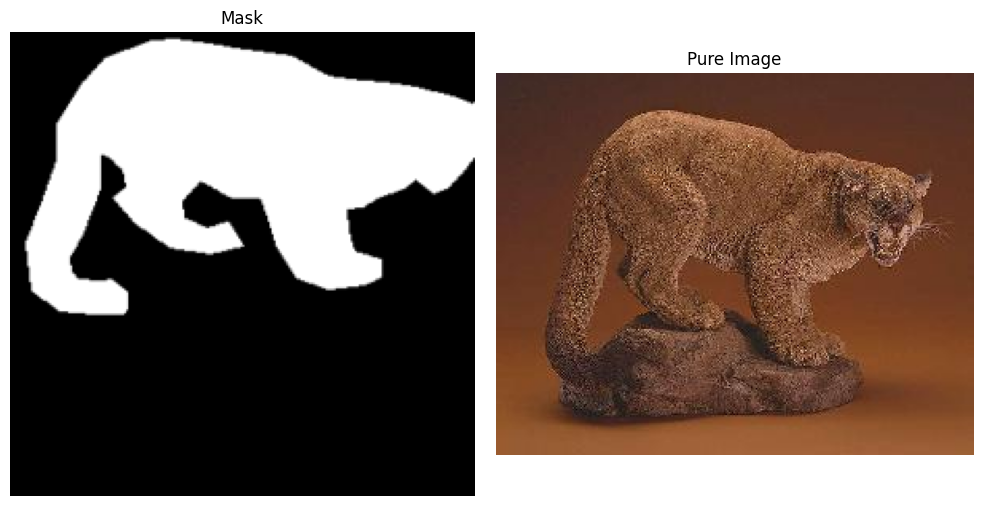

In [272]:
index = 10
_,mask = training.__getitem__(index)
print(label)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Adjust figsize to control the size
# Display the mask
axes[0].imshow(mask.squeeze(),cmap="gray")  # Assuming `mask` is grayscale
axes[0].set_title("Mask")
axes[0].axis('off')  # Hide axes
# Display the pure image
axes[1].imshow(training.__getpureimage__(index))  # Assuming `pure_image` is RGB
axes[1].set_title("Pure Image")
axes[1].axis('off')  # Hide axes
# Show the figure
plt.tight_layout()  # Optional: Adjust spacing between plots
plt.show()

In [273]:
executa()

  0%|          | 0/20 [00:00<?, ?it/s]

Batches (Època 1): 0it [00:00, ?it/s]

AssertionError: 